# Rossmann Stores Sales Forecasting 

## Planeamento da Solução (IOT)

***

## Workspace Setup

### Library Imports

In [1]:
import pandas as pd
import seaborn as sns

import warnings
import re
import math
import datetime

from matplotlib import pyplot as plt
from IPython.core.display import display,HTML,Image

/tmp/ipykernel_22467/3271539233.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display,HTML,Image


### Notebook Settings

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    
    pd.options.display.max_columns = 200
    pd.options.display.max_rows = 700
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
    warnings.filterwarnings("ignore")

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Auxiliar Functions

#### EDA functions

##### Summary Statistics

In [4]:
# Summary Statistical functions

def descriptive_stats(data: pd.DataFrame):
    
    """ A summary statistics with a few
    more statistics metrics like skew and
    kurtosis.
    
    It is meant to help do a descriptive
    analysis.
    
    Parameters
    ----------
    data: pd.DataFrame

    Returns
    ----------
    descriptive_statistics: pd.DataFrame
    """
    
    mean = pd.DataFrame(data.mean())
    std = pd.DataFrame(data.std())
    median = pd.DataFrame(data.median())

    q1,q3 = pd.DataFrame(data.quantile(0.25)), pd.DataFrame(data.quantile(0.75))
    
    iqr = q3[0.75] - q1[0.25]
    q0,q4 = q1[0.25] - (1.5*iqr), q3[0.75] + (1.5*iqr)

    maximum = pd.DataFrame(data.max())
    minimum = pd.DataFrame(data.min())

    skew = pd.DataFrame(data.skew())
    kurtosis = pd.DataFrame(data.kurtosis())

    descriptive_statistics = pd.concat([mean,std,minimum,q0,q1,median,q3,q4,maximum,skew,kurtosis],axis=1)
    
    descriptive_statistics.columns = ['mean','std','minimum','q0','q1','median','q3','q4','maximum','skew','kurtosis']
    
    return descriptive_statistics

def group_descriptive_stats(data: pd.DataFrame, agg_feature: str, info_feature: str):
    
    """ A summary statistics for an aggregation
    of a specific feature category and get a few
    more statistics metrics like skew and
    kurtosis.
    
    It is meant to help do a descriptive
    analysis.
    
    Parameters
    ----------
    data: pd.DataFrame
    agg_feature: str
    info_feature: str

    Returns
    ----------
    grouped_descriptive_statistics: pd.DataFrame
    """
    
    grouped_data = data[[agg_feature,info_feature]].groupby(agg_feature)
    
    mean = grouped_data.mean()
    std = grouped_data.std()
    median = grouped_data.median()

    q1,q3 = grouped_data.quantile(0.25), grouped_data.quantile(0.75)
    
    iqr = q3 - q1
    q0,q4 = q1 - (1.5*iqr), q3 + (1.5*iqr)

    maximum = grouped_data.max()
    minimum = grouped_data.min()

    skew = grouped_data.skew()
    kurtosis = grouped_data.apply(pd.DataFrame.kurt).drop(agg_feature,axis=1)
    
    grouped_descriptive_statistics = pd.concat([mean,std,minimum,q0,q1,median,q3,q4,maximum,skew,kurtosis],axis=1)
    
    grouped_descriptive_statistics.columns = ['mean','std','minimum','q0','q1','median','q3','q4','maximum','skew','kurtosis']
    
    return grouped_descriptive_statistics

def select_num_attr(data: pd.DataFrame):
    
    """ Get only the numeric part
    of a DataFrame.
    
    Parameters
    ----------
    data: pd.DataFrame

    Returns
    ----------
    numeric_data: pd.DataFrame
    """
    
    return data.select_dtypes(include=['int64', 'float64'])

## 0. Data Collection

### 0.1 Loading Data

In [5]:
!ls ../data

sample_submission.csv  store.csv  test.csv  train.csv


In [6]:
sales_df = pd.read_csv('../data/train.csv')
stores_df = pd.read_csv('../data/store.csv')

## 1. Data Integration

### 1.1 Merge Sales and Store data

In [7]:
stores_sales_df = pd.merge(sales_df,stores_df, how='left', on='Store')

### 1.2 General Info

In [8]:
stores_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


In [9]:
stores_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [10]:
stores_sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1014567.00,693861.00,693861.00,1017209.00,509178.00,509178.00
mean,558.43,4.00,5773.82,633.15,0.83,0.38,0.18,5430.09,7.22,2008.69,0.50,23.27,2011.75
std,321.91,2.00,3849.93,464.41,0.38,0.49,0.38,7715.32,3.21,5.99,0.50,14.10,1.66
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,20.00,1.00,1900.00,0.00,1.00,2009.00
25%,280.00,2.00,3727.00,405.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.00,13.00,2011.00
50%,558.00,4.00,5744.00,609.00,1.00,0.00,0.00,2330.00,8.00,2010.00,1.00,22.00,2012.00
75%,838.00,6.00,7856.00,837.00,1.00,1.00,0.00,6890.00,10.00,2013.00,1.00,37.00,2013.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,12.00,2015.00,1.00,50.00,2015.00


### 1.3 Rename Columns

In [11]:
columns = list(stores_sales_df.columns)

cols_single_words = [re.findall("[A-Z][^A-Z]*", column) for column in columns]

cols_lowercase_words = [list(map(lambda x: x.lower(),column)) for column in cols_single_words]

cols_snakecase = ['_'.join(column) for column in cols_lowercase_words]

stores_sales_df.columns = cols_snakecase

stores_sales_df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.4 Change Data Types 

In [12]:
stores_sales_df['date'] = pd.to_datetime(stores_sales_df['date'])

## 2. Data Cleaning

In [13]:
stores_sales_df_cleaning = stores_sales_df.copy(deep=True)

### 2.1 Identify Data Inconsistencies

#### Missing Values

In [14]:
stores_sales_df_cleaning.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [15]:
(stores_sales_df_cleaning.isna().sum()/len(stores_sales_df_cleaning))*100

store                           0.00
day_of_week                     0.00
date                            0.00
sales                           0.00
customers                       0.00
open                            0.00
promo                           0.00
state_holiday                   0.00
school_holiday                  0.00
store_type                      0.00
assortment                      0.00
competition_distance            0.26
competition_open_since_month   31.79
competition_open_since_year    31.79
promo2                          0.00
promo2_since_week              49.94
promo2_since_year              49.94
promo_interval                 49.94
dtype: float64

##### Get missing values per store

To evaluate which strategy to use on missing values. Since the missing values may be originated only by some stores out of the 1115 stores, which could be irrelevant and this records could be discarded. 

Or in the case it is a generalized presence on all stores data attributes, I can then identify if the percentage of missing values is very high on some specific attributeS, and this attributes may not be relevant anymore. 

If the percentage is not so high we can apply an imputation or replacement strategy.

In [16]:
store_agg = stores_sales_df_cleaning.groupby(by='store')

count_na = store_agg.count()

count_na

,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
store,,,,,,,,,,,,,,,,,
1,942,942,942,942,942,942,942,942,942,942,942,942,942,942,0,0,0
2,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942
3,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942
4,942,942,942,942,942,942,942,942,942,942,942,942,942,942,0,0,0
5,942,942,942,942,942,942,942,942,942,942,942,942,942,942,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942
1112,942,942,942,942,942,942,942,942,942,942,942,942,942,942,0,0,0
1113,942,942,942,942,942,942,942,942,942,942,942,0,0,942,0,0,0


In [17]:
# [count_na.iloc[i_store] for i_store in range(len(count_na))]

perc_na_per_store = count_na.apply(lambda x: (x/x[1])*100)

stores_na_filter = [any((perc_na_per_store.iloc[i_store].isna()) | (perc_na_per_store.iloc[i_store] < 100)) for i_store in range(len(perc_na_per_store))]

perc_na_per_store.loc[stores_na_filter]

,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
store,,,,,,,,,,,,,,,,,
1,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
4,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
5,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
6,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
7,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
1112,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,NaN
1113,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,0.00,0.00,100.00,NaN,NaN,NaN


###### Conclusions

Since it is a generalized presence of missing values over almost all stores, those cannot be specifically removed, but according to percentage of each attribute we can choose if it is not worth it continuing with those attributes. Like the promo2 columns could be dropped since almost half of the records are missing.

The other attributes can be filled with some preliminary value on the 1st CRISP cycle, only to allow solution delivery process, and then optimize what could be the best imputation strategy.

#### Missing Records

#### Duplicated Records

### 2.2 Feature Imputation

#### Filling missing values

**Filling NA strategy:**

- **competition_distance** - as the maximum value is 75860.00 a missing value can be replaced by a higher value representing that this store may not have a competitor 
- **competition_open_since_month** - assuming that we have a competitor by looking at the competition distance on each store and check if it is equal or smaller than the original maximum competition distance, I can assume that the competitor is opened since the current daily sales record month
- **competition_open_since_year** - assuming that we have a competitor by looking at the competition distance on each store and check if it is equal or smaller than the original maximum competition distance, I can assume that the competitor is opened since the current daily sales record year

- **promo2_since_week** - assuming that there is really a promotion applied on the store on the current daily sales record, by looking at the binary variable promo2, I can assume that the promotion is applied since the week of this record
- **promo2_since_year** - assuming that there is really a promotion applied on the store on the current daily sales record, by looking at the binary variable promo2, I can assume that the promotion is applied since the year of this record
- **promo_interval** - assuming that it could have been a failure on recording sales procedure, the month interval that the promo is applied it can be replaced by the month of the current daily sales record, only if the promo2 variable is 1. 

In [18]:
aux_df = stores_sales_df_cleaning.copy(deep=True)

# competition_distance
orig_max_competition_dist = aux_df.competition_distance.max()
aux_df.loc[aux_df.competition_distance.isna(),'competition_distance'] = 200000.00

# competition_open_since_month
aux_df.competition_open_since_month = aux_df[['date',
                                              'competition_distance',
                                              'competition_open_since_month']].apply(lambda x: x[0].month if (math.isnan(x[2])) &\
                                                                                                            (x[1] <= orig_max_competition_dist)
                                                                                          else x[2],axis=1)
# competition_open_since_year
aux_df.competition_open_since_year = aux_df[['date',
                                             'competition_distance',
                                             'competition_open_since_year']].apply(lambda x: x[0].year if (math.isnan(x[2])) &\
                                                                                                         (x[1] <= orig_max_competition_dist)
                                                                                        else x[2],axis=1)

# promo2_since_week
aux_df.promo2_since_week = aux_df[['date',
                                   'promo2',
                                   'promo2_since_week']].apply(lambda x: x[0].week if (math.isnan(x[2])) & \
                                                                                                 (x[1] == 1)
                                                                    else x[2],axis=1)

# promo2_since_year 
aux_df.promo2_since_year = aux_df[['date',
                                   'promo2',
                                   'promo2_since_year']].apply(lambda x: x[0].year if (math.isnan(x[2])) & \
                                                                                                 (x[1] == 1)
                                                                    else x[2],axis=1)
# promo_interval
month_dict = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
aux_df.loc[aux_df.promo_interval.isna(),'promo_interval'] = aux_df.date.dt.month.map( month_dict )

aux_df.loc[aux_df.promo2 == 0,'promo_interval'] = np.NaN

In [19]:
aux_df.promo_interval.unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [20]:
aux_df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month      2642
competition_open_since_year       2642
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [21]:
(aux_df.isna().sum()/len(aux_df))*100

store                           0.00
day_of_week                     0.00
date                            0.00
sales                           0.00
customers                       0.00
open                            0.00
promo                           0.00
state_holiday                   0.00
school_holiday                  0.00
store_type                      0.00
assortment                      0.00
competition_distance            0.00
competition_open_since_month    0.26
competition_open_since_year     0.26
promo2                          0.00
promo2_since_week              49.94
promo2_since_year              49.94
promo_interval                 49.94
dtype: float64

###### Conclusion

By filling the competition_open_since_month and competition_open_since_year, if the competition_distance wasn't smaller or equal to the original one before the imputation, it should mean that that store didn't had a competition and ths variables shouldn't be replaced by any value, and must be kept as missing values and then remove them as a record since only 2642 records shows signs of no competitor.

By filling the missing values of promo2_since_week, promo2_since_year and promo_interval with the condition of only filling them if the complete binary attribute of promo2 is set to 1, we can conclude that these stores may not have been doing promotions, so the nan values must be kept and maybe removed.

But to move on and end the 1st CRISP cycle I'll ignore them and fill them on a rationale way.

#### Filling all missing values

In [22]:
# competition_distance
orig_max_competition_dist = stores_sales_df_cleaning.competition_distance.max()
stores_sales_df_cleaning.loc[stores_sales_df_cleaning.competition_distance.isna(),'competition_distance'] = 200000.00

# competition_open_since_month
stores_sales_df_cleaning.competition_open_since_month = stores_sales_df_cleaning[['date',
                                                                                  'competition_open_since_month']].apply(lambda x: x[0].month if (math.isnan(x[1]))
                                                                                                                              else x[1],axis=1)
# competition_open_since_year
stores_sales_df_cleaning.competition_open_since_year = stores_sales_df_cleaning[['date',
                                                                                 'competition_open_since_year']].apply(lambda x: x[0].year if (math.isnan(x[1]))
                                                                                                                            else x[1],axis=1)

# promo2_since_week
stores_sales_df_cleaning.promo2_since_week = stores_sales_df_cleaning[['date',
                                                                       'promo2_since_week']].apply(lambda x: x[0].week if (math.isnan(x[1]))
                                                                                                        else x[1],axis=1)

# promo2_since_year 
stores_sales_df_cleaning.promo2_since_year = stores_sales_df_cleaning[['date',
                                                                       'promo2_since_year']].apply(lambda x: x[0].year if (math.isnan(x[1]))
                                                                                                        else x[1],axis=1)
# promo_interval
month_dict = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
stores_sales_df_cleaning.loc[stores_sales_df_cleaning.promo_interval.isna(),'promo_interval'] = stores_sales_df_cleaning.date.dt.month.map( month_dict )

In [23]:
stores_sales_df_cleaning.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

In [24]:
(stores_sales_df_cleaning.isna().sum()/len(stores_sales_df_cleaning))*100

store                          0.00
day_of_week                    0.00
date                           0.00
sales                          0.00
customers                      0.00
open                           0.00
promo                          0.00
state_holiday                  0.00
school_holiday                 0.00
store_type                     0.00
assortment                     0.00
competition_distance           0.00
competition_open_since_month   0.00
competition_open_since_year    0.00
promo2                         0.00
promo2_since_week              0.00
promo2_since_year              0.00
promo_interval                 0.00
dtype: float64

### 2.3 Change Data Types

In [25]:
# competition_open_since_month to int
stores_sales_df_cleaning['competition_open_since_month'] = stores_sales_df_cleaning['competition_open_since_month'].astype('int64')

# competition_open_since_year to int
stores_sales_df_cleaning['competition_open_since_year'] = stores_sales_df_cleaning['competition_open_since_year'].astype('int64')

# promo2_since_week to int
stores_sales_df_cleaning['promo2_since_week'] = stores_sales_df_cleaning['promo2_since_week'].astype('int64')

# promo2_since_year to int
stores_sales_df_cleaning['promo2_since_year'] = stores_sales_df_cleaning['promo2_since_year'].astype('int64')

stores_sales_df_cleaning.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

### 2.4 Feature and Record Selection

#### 2.4.1 Based on Business Assumptions

In [26]:
stores_sales_df_cleaning = stores_sales_df_cleaning.loc[(stores_sales_df_cleaning['open'] != 0) & (stores_sales_df_cleaning['sales'] > 0)]

stores_sales_df_cleaning.shape

(844338, 18)

## 3. Feature Engineering

In [27]:
stores_sales_df_feng = stores_sales_df_cleaning.copy(deep=True)

### 3.1 Create new variables

In [28]:
# year
stores_sales_df_feng['year'] = stores_sales_df_feng['date'].dt.year

# month
stores_sales_df_feng['month'] = stores_sales_df_feng['date'].dt.month

# day
stores_sales_df_feng['day'] = stores_sales_df_feng['date'].dt.day

# week_of_year
stores_sales_df_feng['week_of_year'] = stores_sales_df_feng['date'].dt.week

# year-week format
stores_sales_df_feng['year_week'] = stores_sales_df_feng['date'].dt.strftime('%Y-%W')

# competition_since
stores_sales_df_feng['competition_since'] = stores_sales_df_feng.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                                                               month=x['competition_open_since_month'],
                                                                                                               day=1), axis=1)
stores_sales_df_feng['competition_time_month'] = ( (stores_sales_df_feng['date'] - stores_sales_df_feng['competition_since'])/30 ).apply(lambda x: x.days).astype(int) 

# promo_since
# since the attributes promo2_since_year and week are integers and we want the as datetime format, we need to convert them into string first
stores_sales_df_feng['promo_since'] = stores_sales_df_feng['promo2_since_year'].astype(str) + '-' + stores_sales_df_feng['promo2_since_week'].astype(str)
# this will return for each date with Year-WeekofYear-WeekDay format as a string, the respective date in datetime Year-Month-Day format
stores_sales_df_feng['promo_since'] = stores_sales_df_feng['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w'))
# calculate in how much weeks the competition has opened on each daily sales record 
stores_sales_df_feng['promo_time_week'] = ((stores_sales_df_feng['date'] - stores_sales_df_feng['promo_since'])/7).apply(lambda x: x.days ).astype(int)

# assortment
stores_sales_df_feng['assortment'] = stores_sales_df_feng['assortment'].apply(lambda x: 'basic' if x=='a'
                                                                                   else 'extra' if x=='b'
                                                                                   else 'extended') 

# state_holiday
stores_sales_df_feng['state_holiday'] = stores_sales_df_feng['state_holiday'].apply(lambda x: 'public_holiday' if x=='a'
                                                                                         else 'easter_holiday' if x=='b'
                                                                                         else 'christmas' if x=='c'
                                                                                         else 'regular_day') 

#### Drop the unnecessary auxiliar

In [29]:
# Drop the auxiliar columns from the feature engineering step and open since now all the records are from when the stores are opened
cols_drop = ['open','competition_since','promo_since']

stores_sales_df_feng = stores_sales_df_feng.drop(cols_drop,axis=1)

## 4. Exploratory Data Analysis

In [30]:
stores_sales_df_eda = stores_sales_df_feng.copy(deep=True)

### 4.1 Data Dimensionality

In [31]:
print('Number of Rows:{}'.format(stores_sales_df_eda.shape[0]))
print('Number of Columns {}'.format(stores_sales_df_eda.shape[1]))

Number of Rows:844338
Number of Columns 24


In [32]:
print(f'Number of Unique Stores: {len(stores_sales_df_eda.store.unique())}')

Number of Unique Stores: 1115


### 4.2 Attributes Names and Description

**Store (categorical)** - a unique Id for each store

**Assortment (categorical)** - describes an assortment level: a = basic, b = extra, c = extended

**Competition Distance (ordered quantitative ratio)** - distance in meters to the nearest competitor store

**DayOfWeek (ordered ordinal)** - the day of the week the record was taken

**Date (ordered quantitative continuous)** - the current date which an instance was recorded

**Sales (ordered ordinal)** - the turnover for any given day

**Customers (ordered ordinal)** - the number of customers on a given day

**Open (categorical binary asymmetric)** - an indicator for whether the store was open: 0 = closed, 1 = open

**Promo (categorical binary asymmetric)** - indicates whether a store is running a promo on that day

**StateHoliday (categorical binary asymmetric)** - indicates if there's a state on that day.

**SchoolHoliday (categorical binary asymmetric)** - indicates if the (Store, Date) was affected by the closure of public schools

### 4.3 Attributes Descriptive Statistics (Summary Statistics)

#### Numerical attributes

In [33]:
num_attr_df = select_num_attr(stores_sales_df_eda)

In [34]:
descriptive_stats(num_attr_df)

,mean,std,minimum,q0,q1,median,q3,q4,maximum,skew,kurtosis
store,558.42,321.73,1.00,-555.50,280.00,558.00,837.00,1672.50,1115.00,0.00,-1.20
day_of_week,3.52,1.72,1.00,-2.50,2.00,3.00,5.00,9.50,7.00,0.02,-1.26
sales,6955.96,3103.82,46.00,-392.50,4859.00,6369.00,8360.00,13611.50,41551.00,1.59,4.85
customers,762.78,401.19,8.00,-42.00,519.00,676.00,893.00,1454.00,7388.00,2.79,13.32
promo,0.45,0.50,0.00,-1.50,0.00,0.00,1.00,2.50,1.00,0.22,-1.95
school_holiday,0.19,0.40,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.55,0.41
competition_distance,5961.83,12592.18,20.00,-8590.00,710.00,2330.00,6910.00,16210.00,200000.00,10.13,145.29
competition_open_since_month,6.79,3.31,1.00,-5.00,4.00,7.00,10.00,19.00,12.00,-0.05,-1.23
competition_open_since_year,2010.33,5.50,1900.00,1999.00,2008.00,2012.00,2014.00,2023.00,2015.00,-7.22,123.90
promo2,0.50,0.50,0.00,-1.50,0.00,0.00,1.00,2.50,1.00,0.01,-2.00


In [35]:
group_descriptive_stats(num_attr_df,'store','sales')

,mean,std,minimum,q0,q1,median,q3,q4,maximum,skew,kurtosis
store,,,,,,,,,,,
1,4759.10,1012.11,2362,1978.00,4000.00,4647.00,5348.00,7370.00,9528,0.93,1.56
2,4953.90,1610.15,1919,380.62,3846.75,4783.00,6157.50,9623.62,10682,0.52,0.15
3,6942.57,2193.38,2936,344.25,5217.00,6619.00,8465.50,13338.25,15689,0.60,0.09
4,9638.40,1936.03,5869,4735.38,8240.50,9430.50,10577.25,14082.38,17412,0.97,1.43
5,4676.27,1765.75,1423,443.75,3635.00,4616.00,5762.50,8953.75,11692,0.35,0.15
...,...,...,...,...,...,...,...,...,...,...,...
1111,5251.70,1667.62,1773,784.25,4028.00,5028.00,6190.50,9434.25,12492,0.85,0.93
1112,10236.58,3334.92,4895,1345.50,7797.00,9410.00,12098.00,18549.50,25165,1.30,1.92
1113,6627.86,1456.49,4050,3016.62,5585.00,6354.50,7297.25,9865.62,16115,1.60,4.64


##### Statistical Interpretation 

Interpret each attribute central tendency, dispersion:

**sales** - I can say that daily sales can range between 46\\$ and 41551\\$ (considering all stores). Then I can conclude that 25\% of the daily sales records (considering all stores) has a total equal or less than 4859\\$, up to 50\%  of the records got 6369\% of daily sales or less, and 75\% makes at least 8360\%. Comparing the mean and median I can conclude that the sales distribution is skewed to the right, since the mean minus the median is equal to (6955.96 - 6369.00 = 586.96\$) with a skew value equal to 1.59. The kurtosis and standard deviation points out that the sales dispersion is higher than a normal distribution, so it dilutes a little bit around the median, having a heavier tailed distribution, i.e. it hasn't many outliers.

**customers** -

#### Categorical Attributes

##### Before Data Cleaning and Feature Engineering

In [36]:
cat_attr_df = stores_sales_df.select_dtypes(exclude='number')

cat_attr_df.apply(lambda x: x.unique().shape[0])

date              942
state_holiday       5
store_type          4
assortment          3
promo_interval      4
dtype: int64

In [37]:
cat_attr_df.state_holiday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

[Text(0, 0, 'Jan,Apr,Jul,Oct'),
 Text(1, 0, 'Mar,Jun,Sept,Dec'),
 Text(2, 0, 'Feb,May,Aug,Nov')]

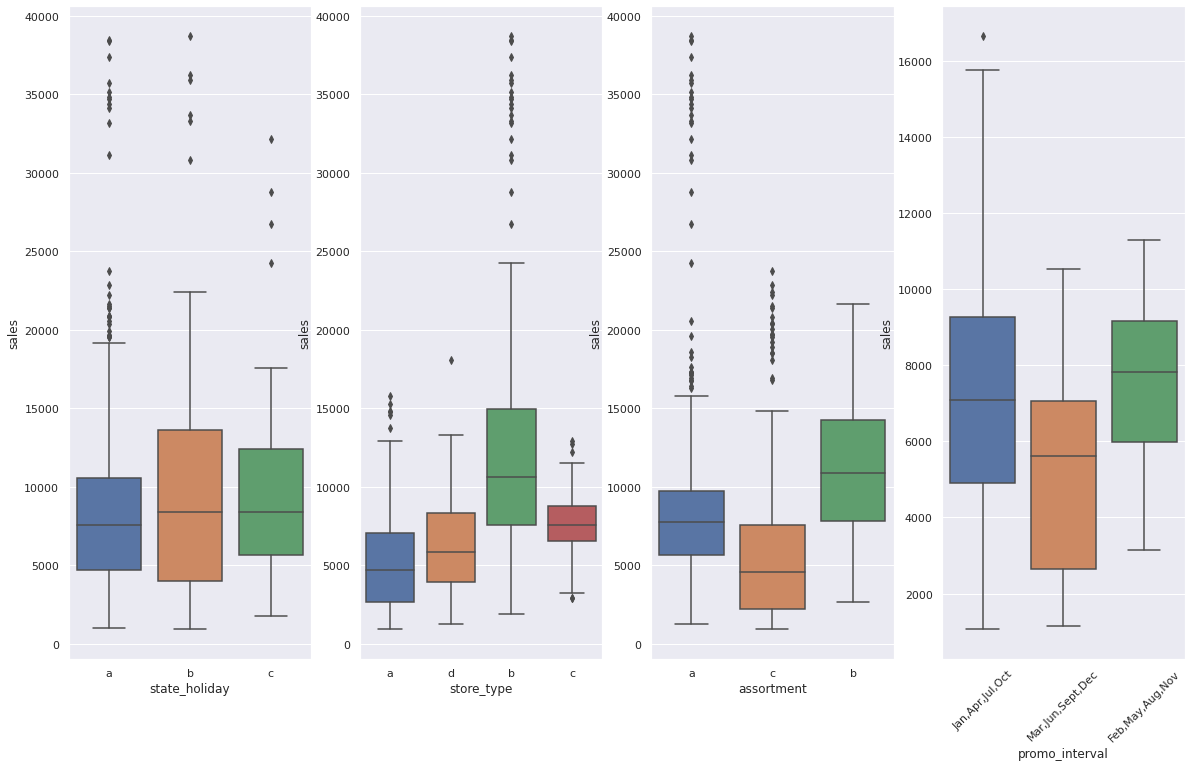

In [38]:
# to get a better interpretation of selling distribution and boxplot I must filter the daily records from when the store was closed during the week and the state holidays
opened_days_records = stores_sales_df.loc[(stores_sales_df.state_holiday != '0') & (stores_sales_df.state_holiday != 0) & (stores_sales_df['open'] != 0) & (stores_sales_df['sales'] > 0)] 

plt.subplot(1, 4, 1)
ax1 = sns.boxplot(x='state_holiday', y='sales', data=opened_days_records)

plt.subplot(1, 4, 2)
ax2 = sns.boxplot(x='store_type', y='sales', data=opened_days_records)

plt.subplot(1, 4, 3)
ax3 = sns.boxplot(x='assortment', y='sales', data=opened_days_records)

plt.subplot(1, 4, 4)
ax4 = sns.boxplot(x='promo_interval', y='sales', data=opened_days_records)
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=45)

###### Statistical Interpretation 

Interpret each attribute central tendency, dispersion:

**store_type** - 25% of the stores of store_type b have already higher daily sales than the other ones.

**assortment** - 25% of the stores of assortment type b have already higher daily sales than the other assortments, so extra products seems to have more purchases or the value can be higher (confirm)

##### After Data Cleaning and  Feature Engineering

In [39]:
cat_attr_df = stores_sales_df_eda.select_dtypes(exclude='number')

cat_attr_df.apply(lambda x: x.unique().shape[0])

date              942
state_holiday       4
store_type          4
assortment          3
promo_interval     15
year_week         137
dtype: int64

In [40]:
cat_attr_df.state_holiday.unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

[Text(0, 0, 'Jan,Apr,Jul,Oct'),
 Text(1, 0, 'Mar,Jun,Sept,Dec'),
 Text(2, 0, 'Feb,May,Aug,Nov')]

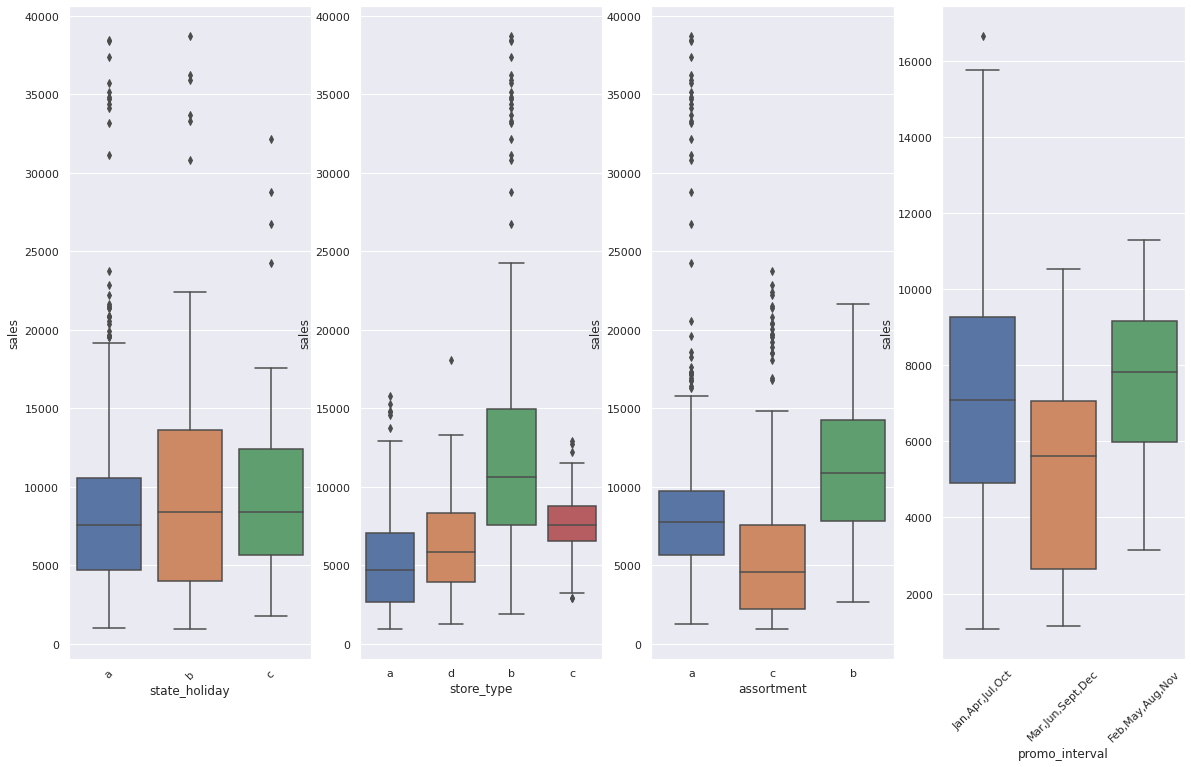

In [41]:
plt.subplot(1, 4, 1)
ax1 = sns.boxplot(x='state_holiday', y='sales', data=opened_days_records)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

plt.subplot(1, 4, 2)
ax2 = sns.boxplot(x='store_type', y='sales', data=opened_days_records)

plt.subplot(1, 4, 3)
ax3 = sns.boxplot(x='assortment', y='sales', data=opened_days_records)

plt.subplot(1, 4, 4)
ax4 = sns.boxplot(x='promo_interval', y='sales', data=opened_days_records)
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=45)

###### Statistical Interpretation 

Interpret each attribute central tendency, dispersion:

**store_type** - 

**assortment** - 

### 4.4 Data Inconsistency

There are negative days on competition_since, telling that there are some daily sales records that register a future date on the opening of a competitor store (it could have been from the imputation) 

There are negative days on promo_time_week, telling that there are some daily sales records that register a future date of a promotion (it could have been from the imputation)

### 4.5 Data Distribution

#### Target Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

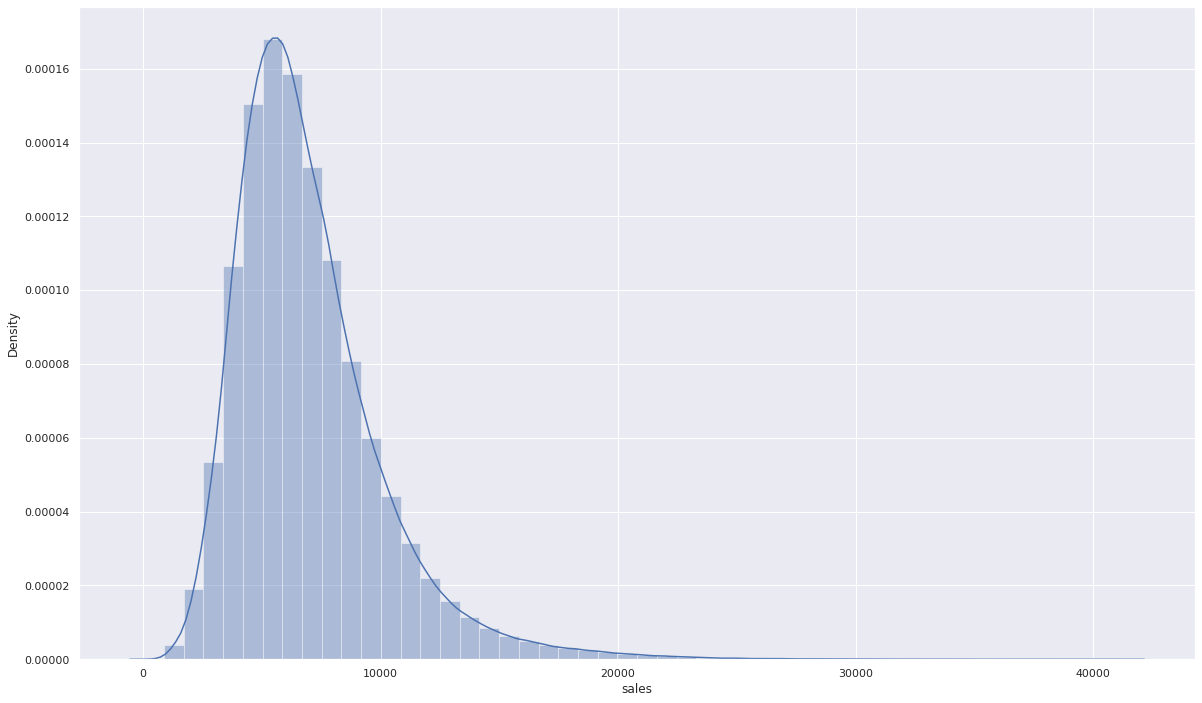

In [42]:
sns.distplot(stores_sales_df_eda.sales)

#### Numerical Variables

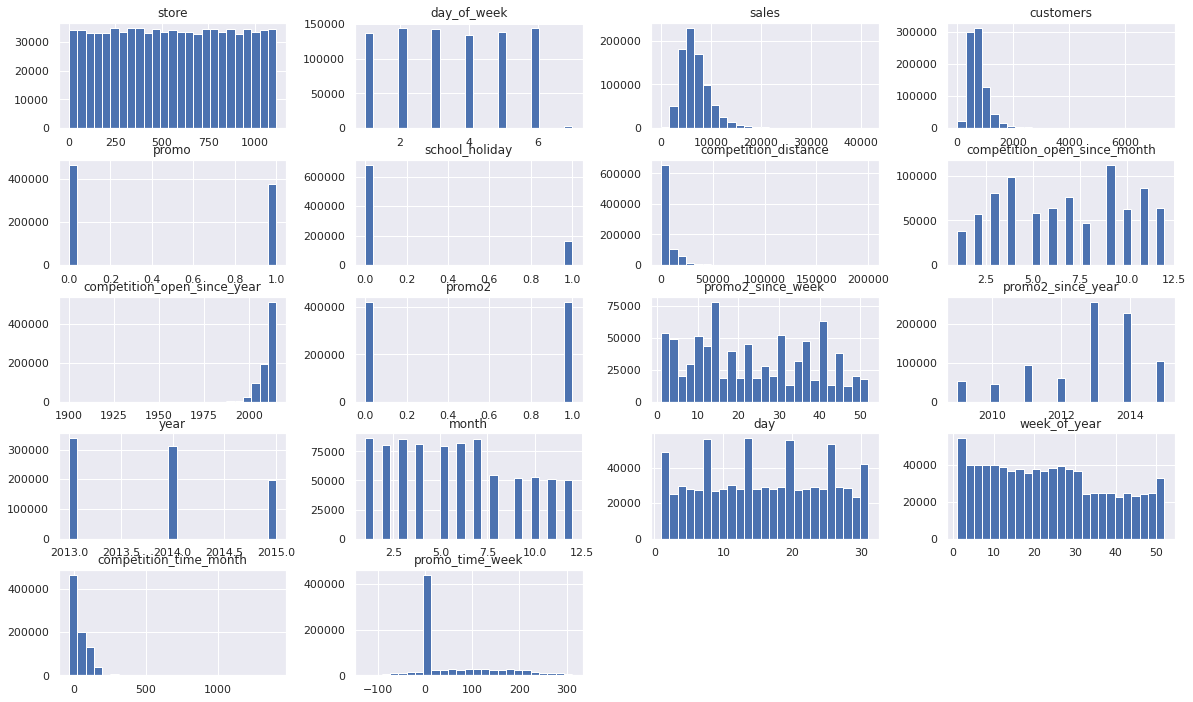

In [43]:
num_attr_df.hist(bins=25);

#### Categorical Variables

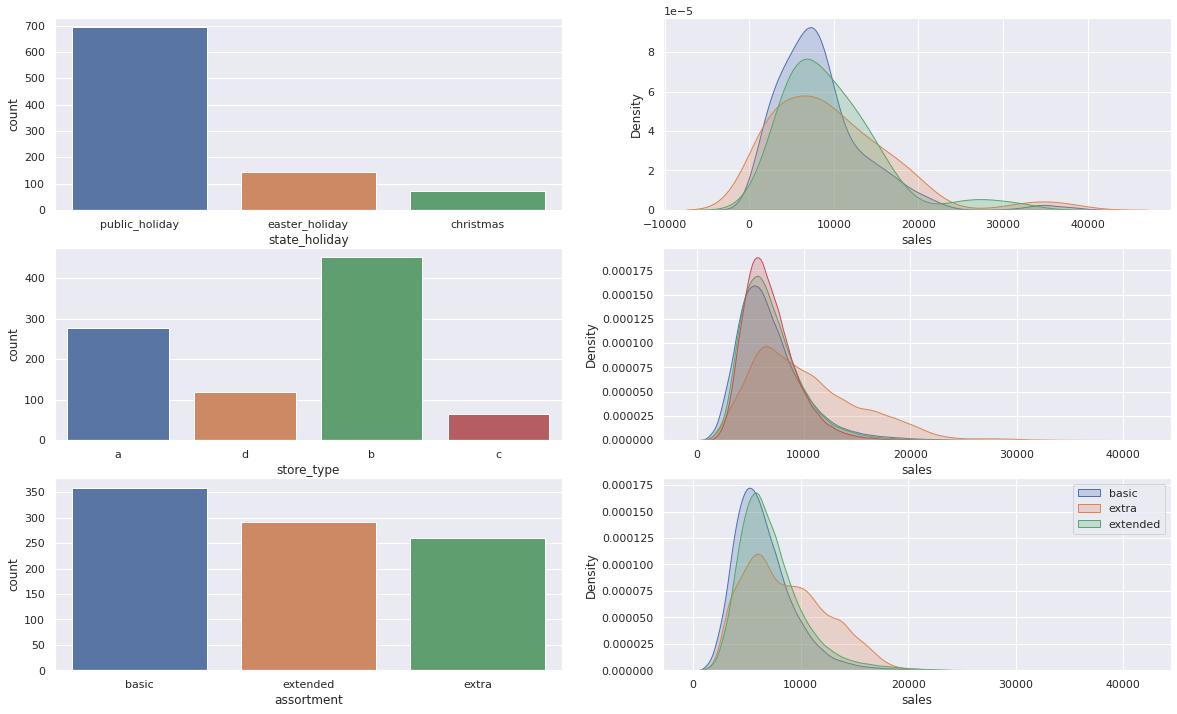

In [44]:
# state holiday
aux_cat_df = cat_attr_df.loc[cat_attr_df['state_holiday'] != 'regular_day']

plt.subplot(3,2,1)
sns.countplot(aux_cat_df.state_holiday)

plt.subplot(3,2,2)
sns.kdeplot(stores_sales_df_eda[stores_sales_df_eda['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(stores_sales_df_eda[stores_sales_df_eda['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(stores_sales_df_eda[stores_sales_df_eda['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3,2,3)
sns.countplot(aux_cat_df.store_type)

plt.subplot(3,2,4)
sns.kdeplot(stores_sales_df_eda[stores_sales_df_eda['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(stores_sales_df_eda[stores_sales_df_eda['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(stores_sales_df_eda[stores_sales_df_eda['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(stores_sales_df_eda[stores_sales_df_eda['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(aux_cat_df.assortment)

plt.subplot(3,2,6)
sns.kdeplot(stores_sales_df_eda[stores_sales_df_eda['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(stores_sales_df_eda[stores_sales_df_eda['assortment'] == 'extra']['sales'], label='extra', shade=True)
sns.kdeplot(stores_sales_df_eda[stores_sales_df_eda['assortment'] == 'extended']['sales'], label='extended', shade=True)


plt.legend()


### 4.6 Data Sparsity

### 4.10 Define Business Data Assumptions and Hypothesis

#### 4.10.1 Features Mindmap

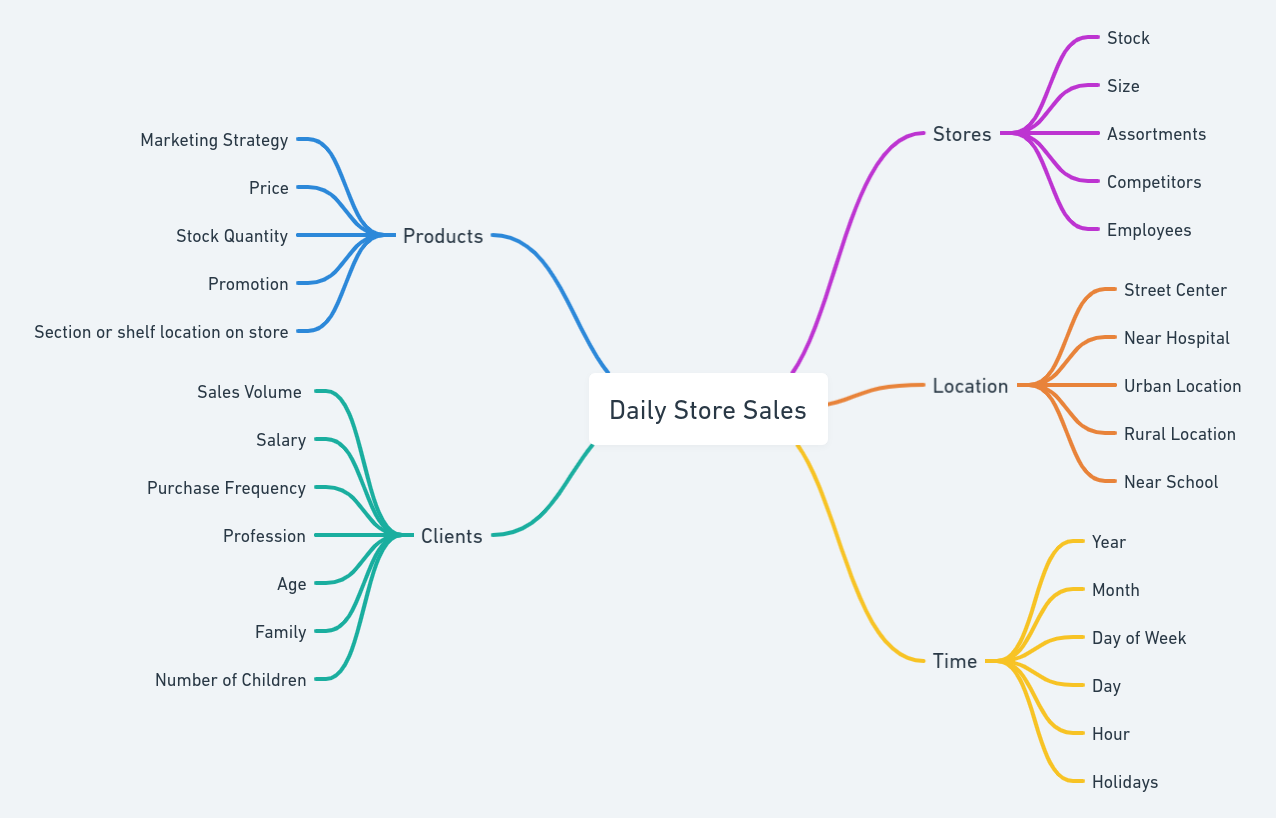

In [45]:
Image('../images/rossmann-features-mindmap.png')

#### 4.10.2 Business Data Assumptions

1. Records of daily sales when the store is closed and the sales were 0 are not relevant.

#### 4.10.3 Hypothesis

##### Stores hypothesis

**1.** Stores with more employees should be selling more.

**2.** Stores with more stock should be selling more.

**3.** Stores with higher size should be selling more.

**4.** Stores that have a bigger assortment should be selling more

**5.** Stores with closer competitors should be selling less.

**6.** Stores with competitors opened for a longer time period should be selling more.

##### Products hypothesis

**1.** Stores that invest more on new Marketing strategies should be selling more.

**2.** Stores that expose more the products on showcases should be selling more.

**3.** Stores that sell cheaper products should be selling more.

**4.** Stores with promotions applied for longer period of time should be selling more.

**5.** Stores with more consecutive promotions periods should be selling more.

##### Time Hypothesis

**1.** Stores that are closed on a lot of public holidays should be selling less.

**2.** Stores that open on the first 6 months should be selling more.

**3.** Stores that open on weekends should be selling more.

**4.** Stores are selling more in the beginning of the month instead of the end of the month.

**5.** Stores should be selling more on the second semester.

**6.** Stores should be selling more Year over Year.

##### Final Hypothesis (feasible ones)

**1.** Stores that have a bigger assortment should be selling more

**2.** Stores with closer competitors should be selling less.

**3.** Stores with competitors opened for a longer time period should be selling more.

**4.** Stores are selling more in the beginning of the month instead of the end of the month.

**5.** Stores with promotions applied for longer period of time should be selling more.

**6.** Stores with more consecutive promotions periods should be selling more.

**7.** Stores that are closed on a lot of public holidays should be selling less.

**8.** Stores that open on the first 6 months should be selling more.

**9.** Stores that open on weekends should be selling more.

**10.** Stores are selling more in the beginning of the month instead of the end of the month.

**11.** Stores should be selling more on the second semester.

**12.** Stores should be selling more Year over Year.

#### 4.10.4 Test Hypothesis with Bivariate Analysis

#### H1. Stores that have a bigger assortment should be selling more

Assuming that *extended* should be a "bigger" assortment than the *basic* one, and the extra is a type of products that are for rare necessities, this hypothesis is **FALSE**, since overall the basic sells more than the extended.

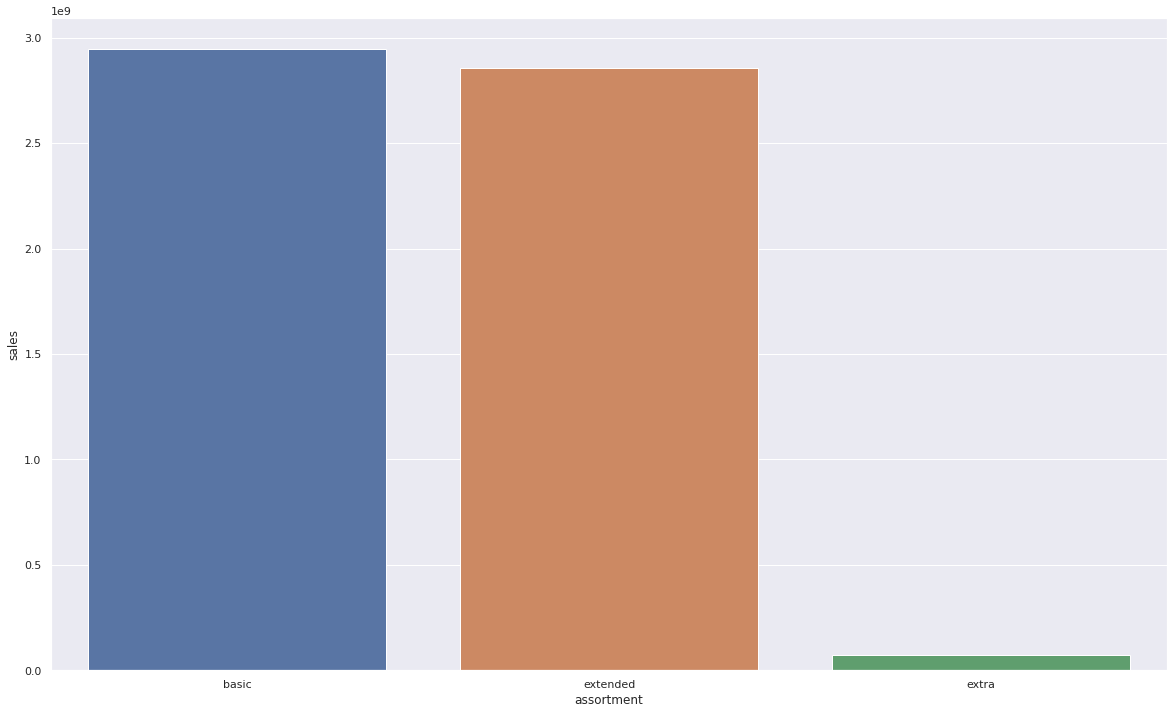

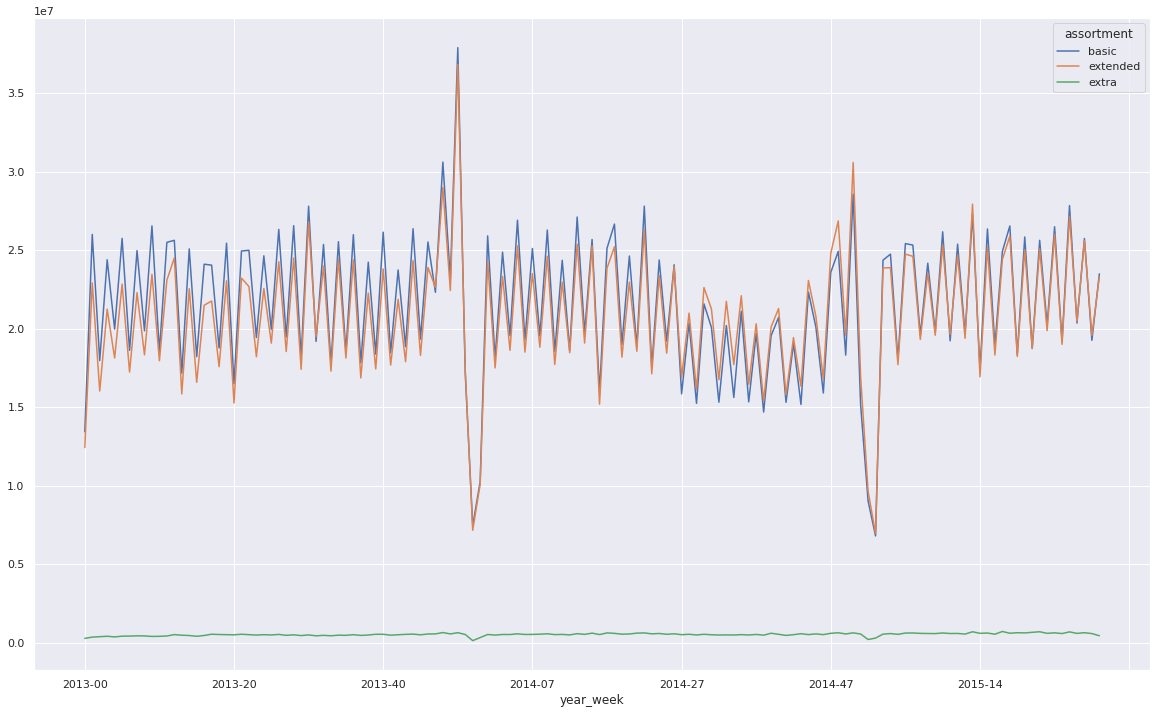

In [46]:
sales_per_assortment = stores_sales_df_eda[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=sales_per_assortment);

sales_per_week_per_assortment = stores_sales_df_eda[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
pivot_sales_group = sales_per_week_per_assortment.pivot(index='year_week',columns='assortment',values='sales').plot()

#### H2. Stores with closer competitors should be selling less.

**FALSE** Stores with CLOSER competitors are selling MORE.

By looking at the barplot where 30 different intervals of stores competition distances show that only the first two intervals of stores with the closest distances have at least double the sales value. And apart from not showing almost any linear correlation between sales and competition_distance on the heatmap, the value is negative which allows to conclude as well that the lowest the distance, the higher the sales.

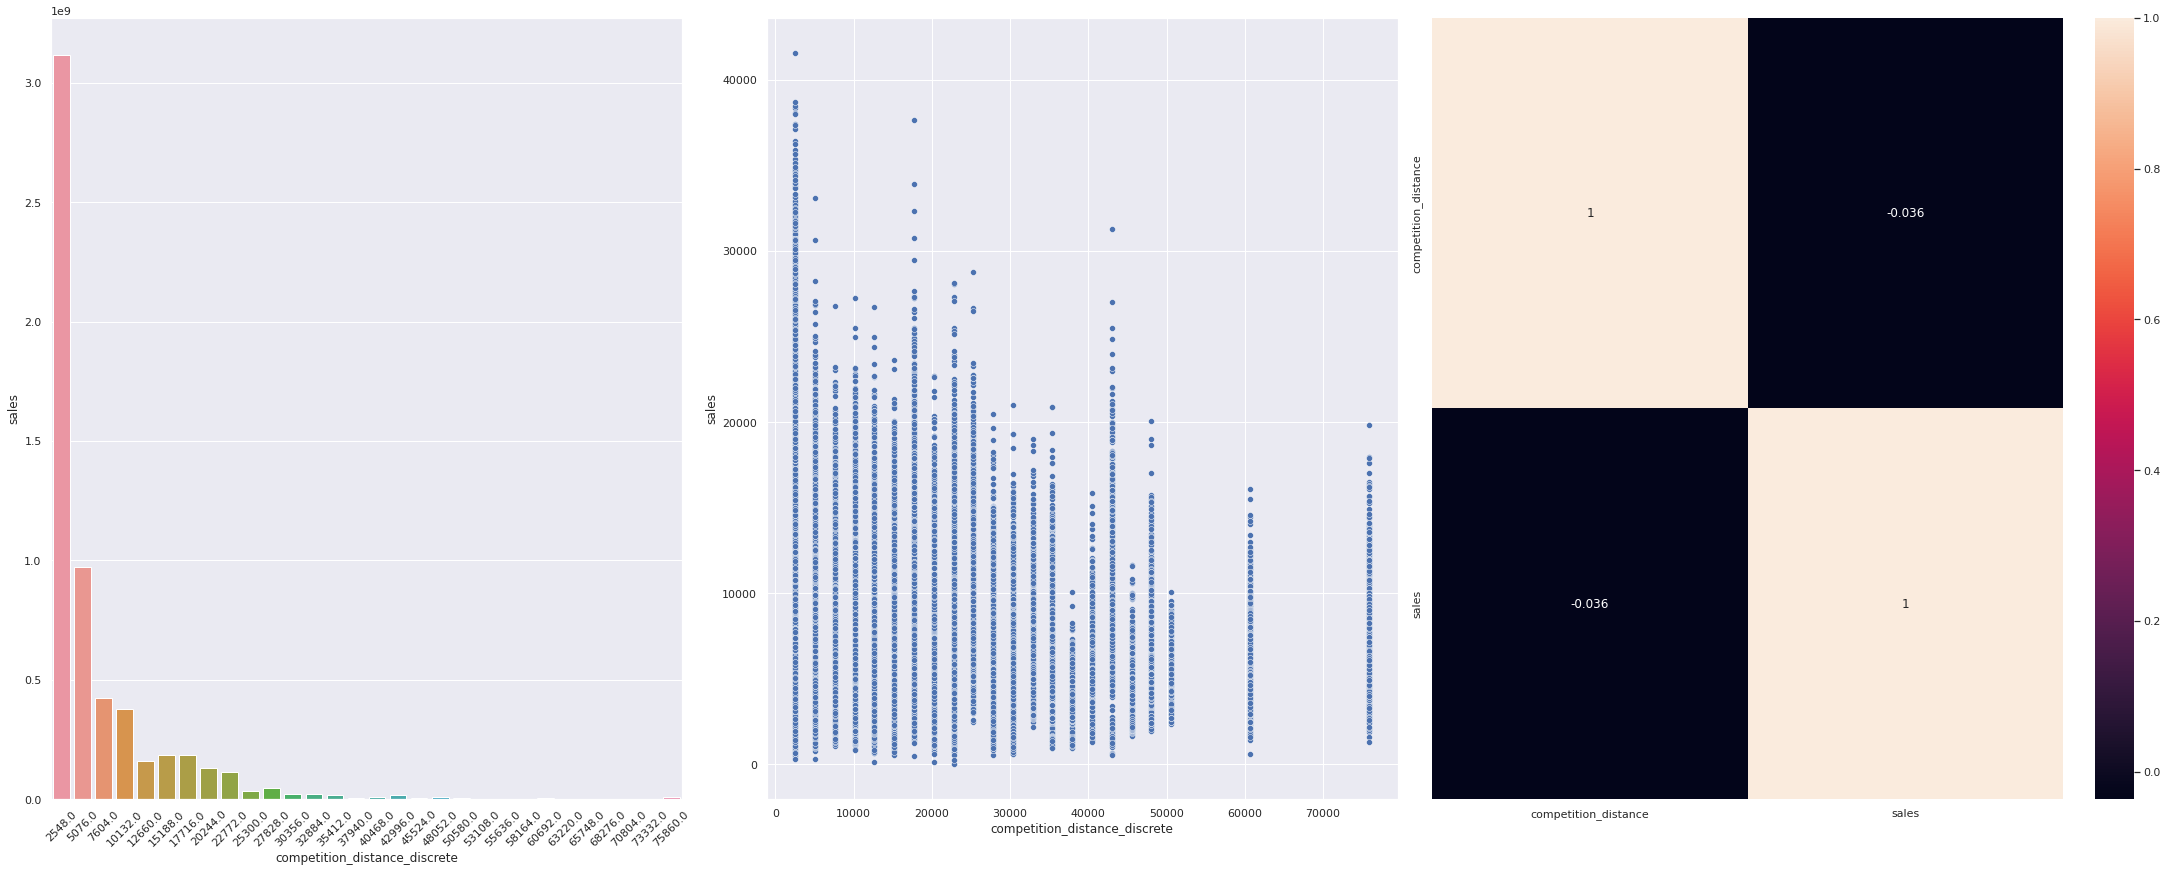

In [75]:
# since the value to fill the missing values was 200000, and the previous maximum value was ~78000
aux_hyp_df = stores_sales_df_eda.loc[stores_sales_df_eda['competition_distance']<100000]

comp_dist_bins = pd.cut(aux_hyp_df['competition_distance'],30,retbins=True)[1].round(2)
aux_hyp_df['competition_distance_discrete'] = pd.cut(aux_hyp_df['competition_distance'],bins=comp_dist_bins,labels=comp_dist_bins[1:])

aux_hyp_df_grouped = aux_hyp_df[['competition_distance_discrete','sales']].groupby('competition_distance_discrete').sum().reset_index()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 12),
                        constrained_layout=True)
# aux_hyp_df_grouped
sns.barplot(x='competition_distance_discrete',y='sales',data=aux_hyp_df_grouped,ax=axs[0])
axs[0].set_xticklabels(ax1.get_xticklabels(),rotation=45);

# scatterplot
sns.scatterplot(x='competition_distance_discrete',y='sales',data=aux_hyp_df, ax=axs[1]);

# correlation heatmap
sns.heatmap(aux_hyp_df[['competition_distance','sales']].corr(method='pearson'), annot=True, ax=axs[2]);

#### H3. Stores with competitors opened for a longer time period should be selling more.

**FALSE** Stores with competitors opened for a LONGER time period is selling LESS.

By looking at the barplot it's noticeable that the sales values are bigger with stores opened more recent than the ones opened for a longer time. And also the low linear correlation implies that the lower the time period the competition is opened the higher the sales value, since the correlation value is negative.

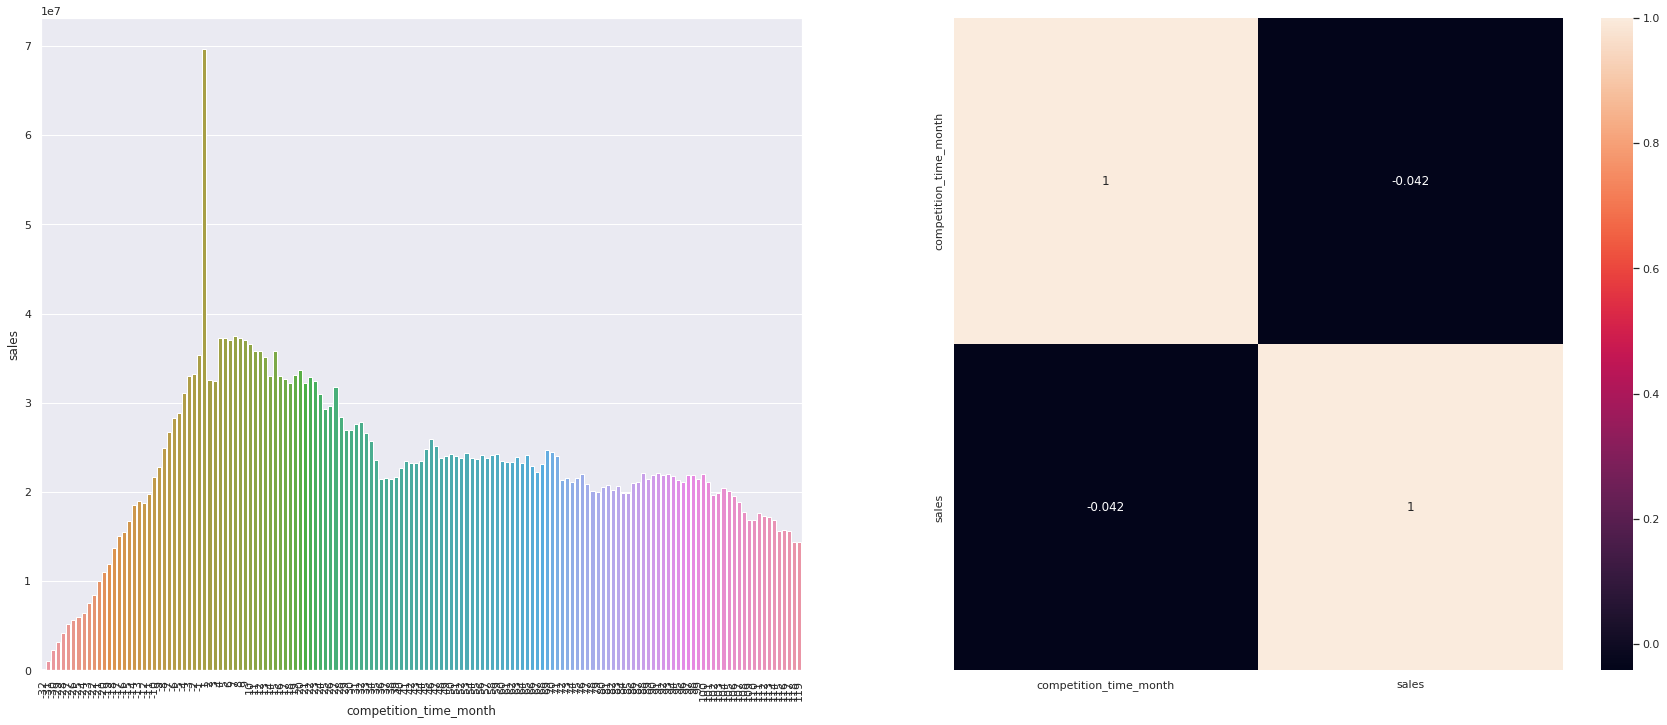

In [85]:
# since when creating this variable there were some records that had the competition_open_since_year and month has a later date compared with the daily sales record, so there are some negative values.
aux_hyp_df = stores_sales_df_eda.loc[ (stores_sales_df_eda['competition_time_month'] < 120) & (stores_sales_df_eda['competition_time_month'] != 0)]

aux_hyp_grouped_df = aux_hyp_df[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30,12))

ax1 = sns.barplot(x='competition_time_month', y='sales', data=aux_hyp_grouped_df, ax=axs[0]);
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90);

sns.heatmap(aux_hyp_df[['competition_time_month','sales']].corr(method='pearson'), annot=True, ax=axs[1]);

#### H4. Stores are selling more in the beginning of the month instead of the end of the month.

#### H5. Stores with promotions applied for longer period of time should be selling more

**FALSE** Stores with promotions applied for LONGER period of time sells LESS.

Even with a low positive linear correlation, indicating that the longer time period the higher the sales, it almost means nothing. And as we can verify throughout the time on barplot and regplot there is a lowering tendency the longer the promotion is applied.

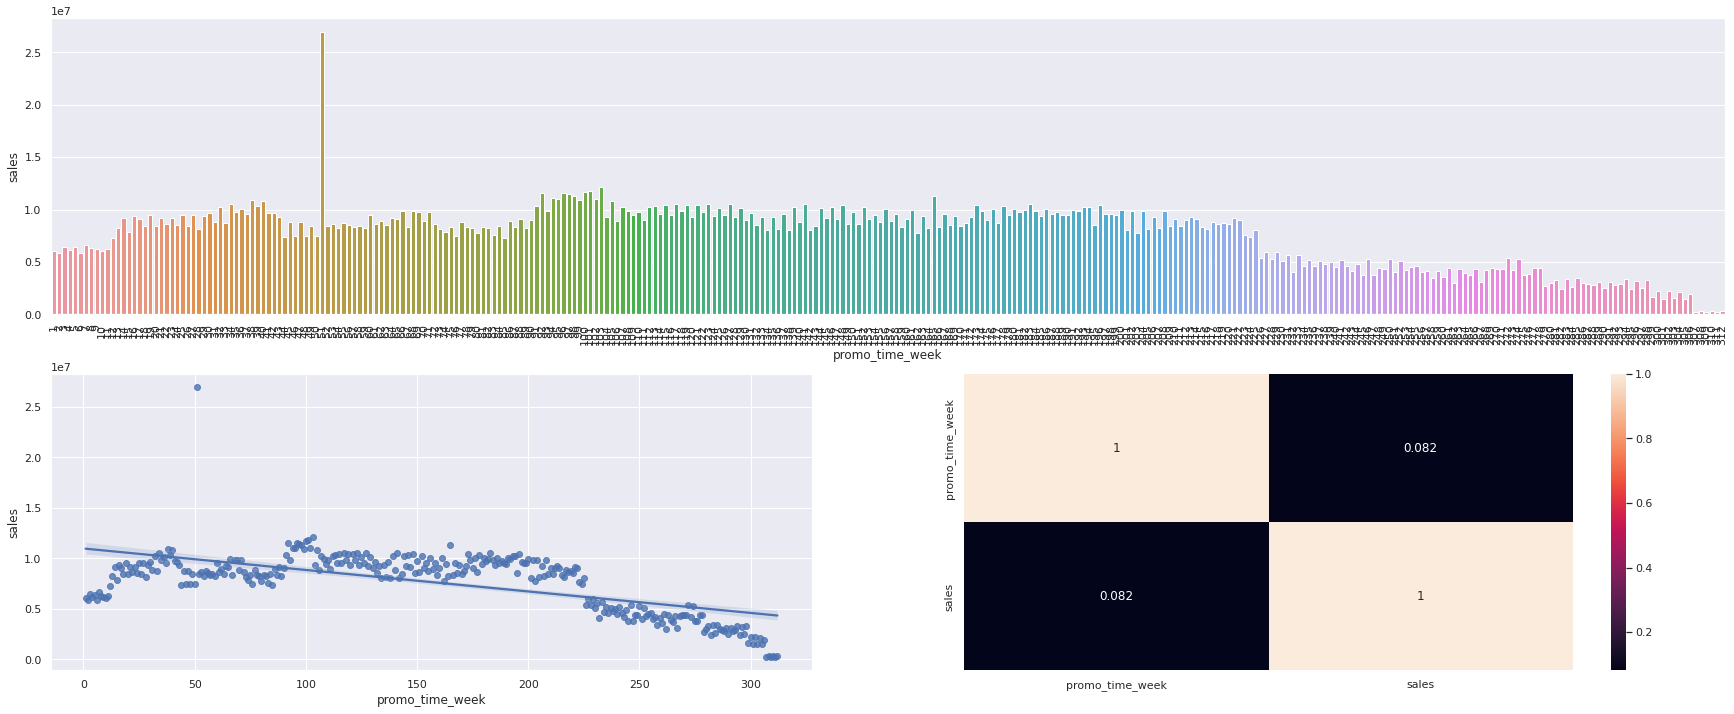

In [92]:
# since when creating this variable there were some records that had the promo_open_since_year and week has a later date compared with the daily sales record, so there are some negative values.
aux_hyp_df = stores_sales_df_eda.loc[ (stores_sales_df_eda['promo_time_week'] > 0)]

aux_hyp_grouped_df = aux_hyp_df[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

fig = plt.figure(figsize=(30,12))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0,:])
sns.barplot(x='promo_time_week', y='sales', data=aux_hyp_grouped_df, ax=ax1);
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90);

ax2 = fig.add_subplot(gs[1,0])
sns.regplot(x='promo_time_week', y='sales', data=aux_hyp_grouped_df, ax=ax2);

ax3 = fig.add_subplot(gs[1,1])
sns.heatmap(aux_hyp_df[['promo_time_week','sales']].corr(method='pearson'), annot=True, ax=ax3);

plt.show()

#### H6. Stores with more consecutive promotions periods should be selling more.

**FALSE** Stores with more CONSECUTIVE promotions periods sells LESS.

Assuming that getting consecutive promotions is applying promo1 and promo2. So by looking at the table ordered by sales for the different promotion application scenarios, the one with more sales is when there is only the first traditional promotion period. And from the lineplot graph it is noticeable as well that throughout all weeks the traditional promotion gets more sales, than both.  

In [94]:
stores_sales_df_eda[['promo','promo2','sales']].groupby( ['promo','promo2'] ).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


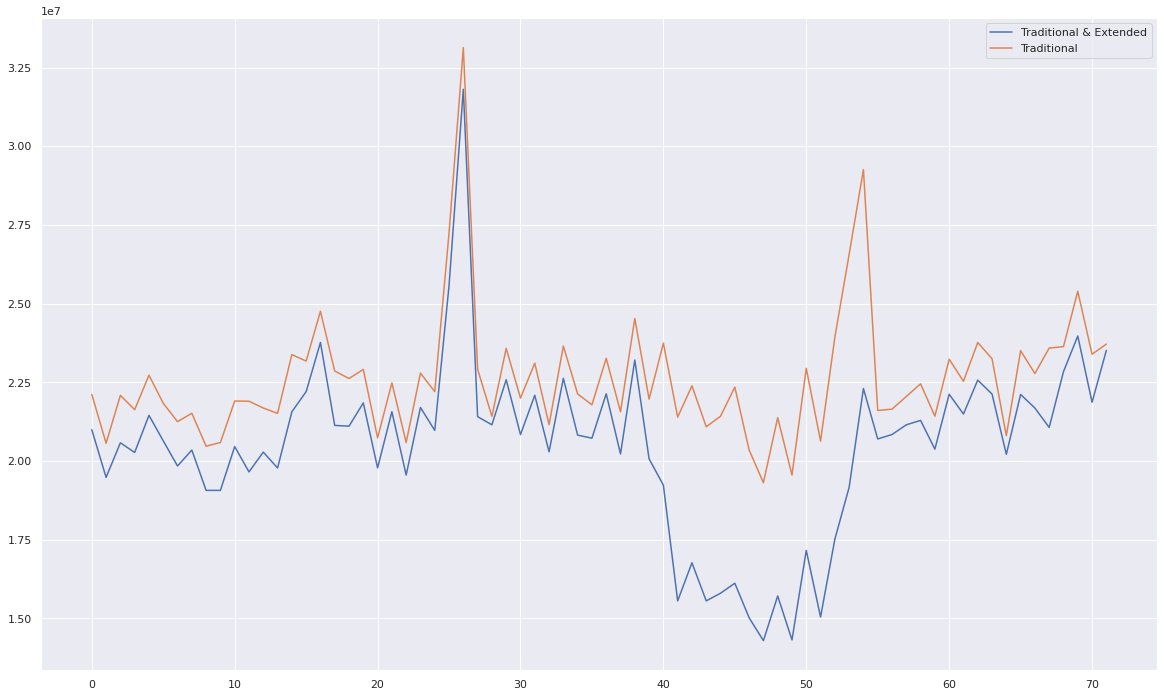

In [96]:
aux = stores_sales_df_eda.loc[(stores_sales_df_eda['promo'] == 1) & (stores_sales_df_eda['promo2'] == 1), ['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux.plot()

aux2 = stores_sales_df_eda.loc[(stores_sales_df_eda['promo'] == 1) & (stores_sales_df_eda['promo2'] == 0), ['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional & Extended', 'Traditional'])

#### H7. Stores that are closed on a lot of public holidays should be selling less.

#### H8. Stores that open on the first 6 months should be selling more.

#### H9. Stores that open on weekends should be selling more.

#### H10. Stores are selling more in the beginning of the month instead of the end of the month.

#### H11. Stores should be selling more on the second semester.

#### H12. Stores should be selling more Year over Year.

#### 4.10.5 Attributes Usefulness for the task

**competition_open_since_month** - it can be important to analyze how much impact the sales could have been suffering since a competition store has opened nearby

## 5. Data Pre-processing

In [ ]:
stores_sales_df_preprocess = stores_sales_df_eda.copy(deep=True)